In [1]:
import os
import pickle

import jax
import jax.numpy as jnp

from variational.exponential_family import GenericNormalDistribution
from variational.exponential_family import GenericTruncatedMFNormalDistribution

OUTPUT_PATH = "./"
OP_key = jax.random.PRNGKey(0)

dim = 3

trunc = GenericTruncatedMFNormalDistribution(dimension=dim, lower=jnp.array([1., 0., 0.]),
                                             upper=jnp.array([2., 100., 0.9]))
gauss = GenericNormalDistribution(dimension=dim)

offsets = jnp.array([1., 0., 0.])
scales = jnp.array([1., 100., 0.9])


def from_params_transform_to_params(params_transform):
    params = jax.scipy.special.expit(params_transform)
    params = offsets + scales * params
    return params


PKLs = []
PKL_titles = []
for file in os.listdir("./"):
    if file.endswith(".pkl"):
        PKLs.append(pickle.load(open(file, "rb")))
        PKL_titles.append(str(file))

In [10]:
for idx, title in enumerate(PKL_titles):
    if "ht_data" not in title:
        print(idx)
        print(PKL_titles[idx])

0
heuristic_gaussian_200_100_inv_u_1_shrinkage_01_[0 2].pkl
1
heuristic_trunc_gaussian_200_100_inv_u_1_shrinkage_05_[0 2].pkl
2
heuristic_trunc_gaussian_200_10_inv_u_1_shrinkage_01_tgtlog10_[0 1].pkl
3
heuristic_trunc_gaussian_200_10_inv_u_1_shrinkage_01_tgtlog10_[0 2].pkl
4
heuristic_trunc_gaussian_200_100_inv_u_1_shrinkage_05_[0 0].pkl
5
heuristic_trunc_gaussian_200_10_inv_u_1_shrinkage_05_[0 1].pkl
6
heuristic_trunc_gaussian_200_10_inv_u_1_shrinkage_01_tgtlog10_[0 0].pkl
7
heuristic_gaussian_200_100_inv_u_1_shrinkage_01_[0 1].pkl
8
heuristic_trunc_gaussian_200_10_inv_u_1_shrinkage_05_[0 2].pkl
9
rwmh_constant_sigma_100_10000_[0 4].pkl
11
heuristic_trunc_gaussian_200_100_inv_u_1_shrinkage_05_[0 1].pkl
12
heuristic_trunc_gaussian_200_10_inv_u_1_shrinkage_05_[0 0].pkl
13
heuristic_gaussian_200_100_inv_u_1_shrinkage_01_[0 0].pkl


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


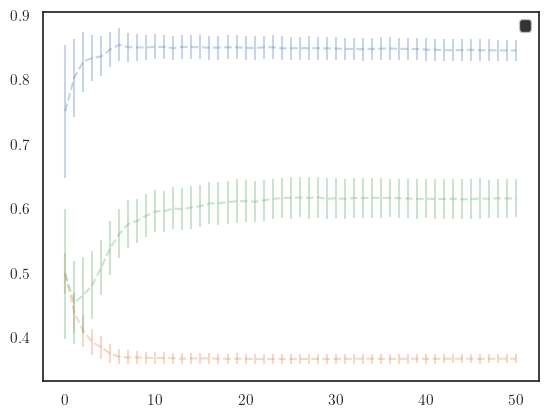

In [15]:
import matplotlib.pyplot as plt
import numpy as np

keys = jax.random.split(OP_key, 10000)
sampling = jax.vmap(trunc.sampling_method, in_axes=(None, 0))
means = list()
stds = list()
titles = list()
for _idx in range(len(PKLs)):
    if "ht_data" not in PKL_titles[_idx] and "trunc" in PKL_titles[_idx] and "100_inv" in PKL_titles[_idx]:
        mypkld = PKLs[_idx]['res']
        size = min(mypkld.shape[0], 51)
        _means = np.zeros((size, 3))
        _std = np.zeros((size, 3))
        for i in range(size):
            keys = jax.random.split(keys.at[-1].get(), 10000)
            samples = sampling(mypkld[i][:-1], keys)
            _means[i] = jnp.mean(samples, axis=0)
            _std[i] = jnp.std(samples, axis=0)
        means.append(_means)
        stds.append(_std)
        titles.append(PKL_titles[_idx])
_scales = [2, 100, 1]
for i in range(3):
    for _idx in range(1):
        plt.errorbar(range(size), means[_idx][:, i] / _scales[i], yerr=stds[_idx][:, i] / _scales[i],
                     label=titles[_idx][-39:], alpha=0.3, linestyle="--")
        #plt.plot(range(size), means[_idx][:,i], label=titles[_idx][-39:], alpha=0.5)
plt.legend()
plt.show()
plt.close()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


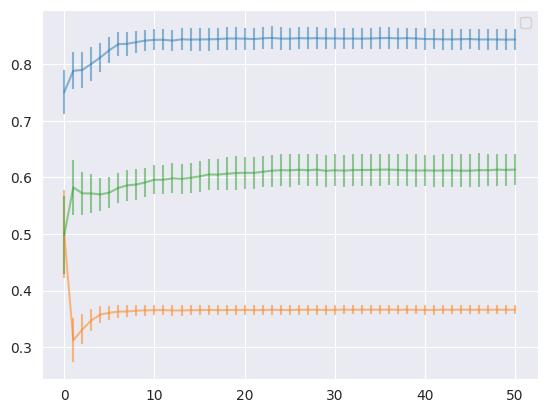

In [8]:
import matplotlib.pyplot as plt
import numpy as np

idx_pkl = np.arange(2, 13)
idx_pkl = [5, 11, 12]
idx_pkl = idx_pkl + [0, 3, 15]
keys = jax.random.split(OP_key, 10000)
sampling = jax.vmap(gauss.sampling_method, in_axes=(None, 0))
means = list()
stds = list()
titles = list()
covs = list()
for _idx in range(len(PKLs)):
    if "ht_data" not in PKL_titles[_idx] and "heuristic_gaussian" in PKL_titles[_idx]:
        mypkld = PKLs[_idx]['res']
        size = min(mypkld.shape[0], 51)
        _means = np.zeros((size, 3))
        _std = np.zeros((size, 3))
        _covs = np.zeros((size, 3, 3))
        for i in range(size):
            keys = jax.random.split(keys.at[-1].get(), 10000)
            samples = from_params_transform_to_params(sampling(mypkld[i][:-1], keys))
            _means[i] = jnp.mean(samples, axis=0)
            _std[i] = jnp.std(samples, axis=0)
            _covs[i] = jnp.cov(samples, rowvar=False)
        means.append(_means)
        stds.append(_std)
        covs.append(_covs)
        titles.append(PKL_titles[_idx])
_scales = [2, 100, 1]
for i in range(3):
    for _idx in range(1):
        plt.errorbar(range(size), means[_idx][:, i] / _scales[i], yerr=stds[_idx][:, i] / _scales[i],
                     label=titles[_idx][-39:], alpha=0.5)
plt.legend()
plt.show()
plt.close()


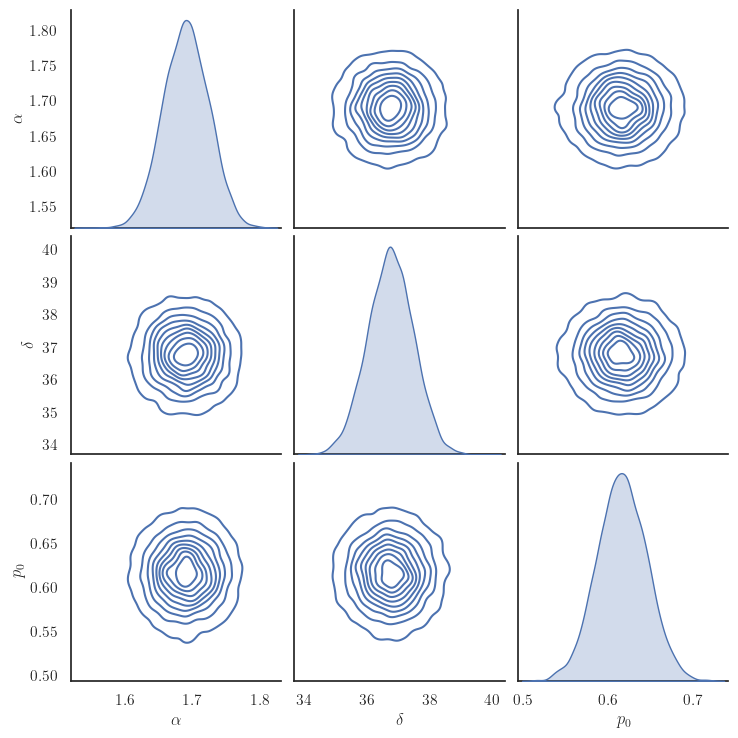

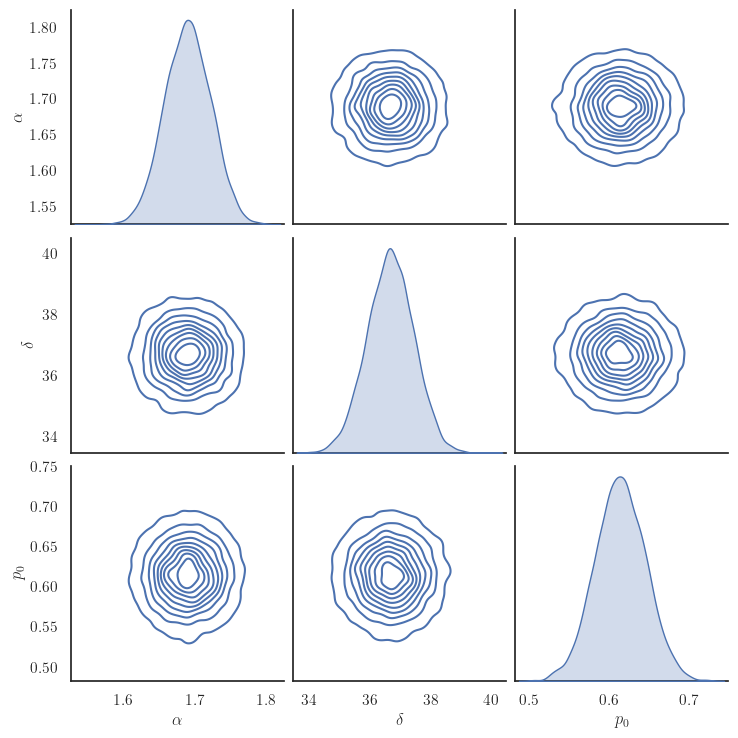

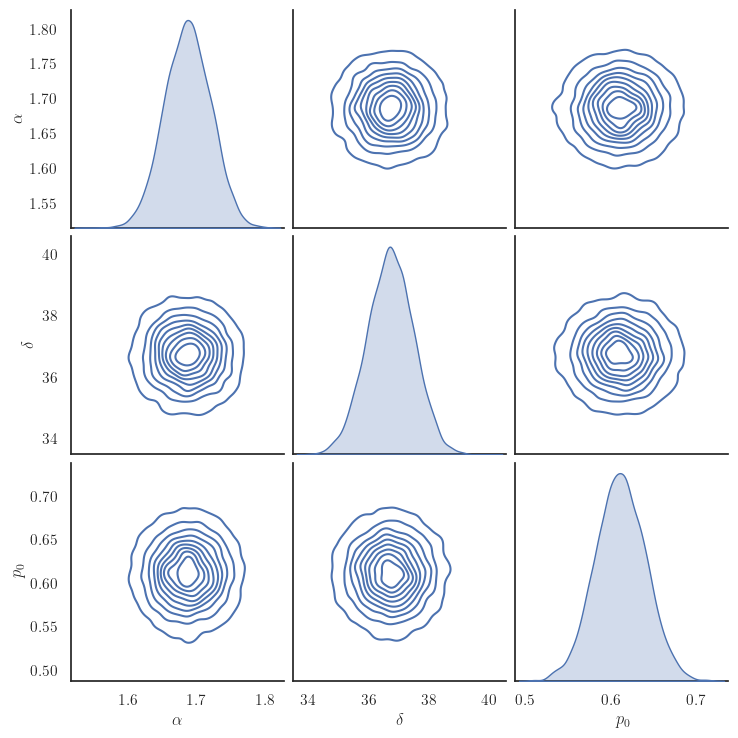

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = True
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

keys = jax.random.split(OP_key, 10000)
sampling = jax.vmap(trunc.sampling_method, in_axes=(None, 0))
vars = [r'$\displaystyle \alpha$', r'$\displaystyle\delta$', r'$\displaystyle p_0$']
for _idx in range(len(PKLs)):
    if "ht_data" not in PKL_titles[_idx] and "trunc" in PKL_titles[_idx] and "100_inv" in PKL_titles[_idx]:
        mypkld = PKLs[_idx]['res']
        samples = sampling(mypkld[51][:-1], keys)
        pd_samples = pd.DataFrame(samples, columns=vars)
        sns.pairplot(pd_samples, kind="kde", vars=vars)
        plt.savefig(f"pairplot_bsl_mft_{_idx}.pdf", dpi=300)



KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7fea04294d60> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

<Figure size 450x300 with 0 Axes>

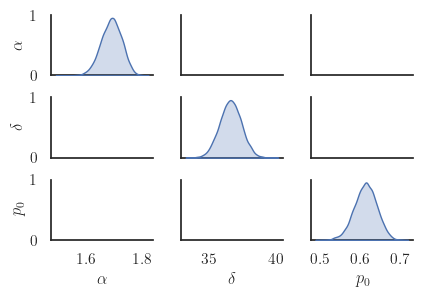

In [36]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import itertools

plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = True
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
keys = jax.random.split(OP_key, 10000)
sampling = jax.vmap(gauss.sampling_method, in_axes=(None, 0))
vars = [r'$\displaystyle \alpha$', r'$\displaystyle\delta$', r'$\displaystyle p_0$']
plt.figure(figsize=(3 * 1.5, 3 * 1))
limdelta = (34, 39)
limp0 = (0.5, 0.75)
limalpha = (1.5, 1.85)
lims = {0: {0: (limalpha, limalpha), 1: (limdelta, limalpha), 2: (limp0, limalpha)},
        1: {0: (limdelta, limalpha), 1: (limdelta, limdelta), 2: (limp0, limdelta)},
        2: {0: (limalpha, limp0), 1: (limdelta, limp0), 2: (limp0, limp0)}
        }
for _idx in range(1):
    if "ht_data" not in PKL_titles[_idx] and "heuristic_gaussian" in PKL_titles[_idx]:
        mypkld = PKLs[_idx]['res']
        samples = from_params_transform_to_params(sampling(mypkld[51][:-1], keys))
        pd_samples = pd.DataFrame(samples, columns=vars)
        g = sns.pairplot(pd_samples, kind="kde", vars=vars, height=1, aspect=1.5)
        for idx1, idx2 in itertools.product(range(3), range(3)):
            g.axes[idx1, idx2].set_xlim(*lims[idx1][idx2][0])
            g.axes[idx1, idx2].set_ylim(*lims[idx1][idx2][1])
        plt.savefig(f"pairplot_bsl_fcg_{_idx}.pdf", dpi=300)

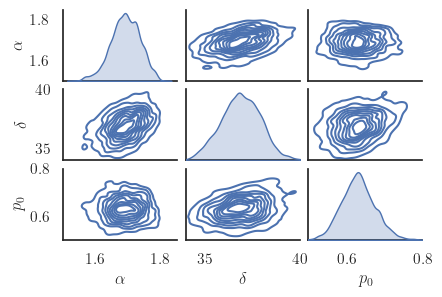

In [15]:
_idx = 9
limdelta = (33, 40)
limp0 = (0.5, 0.8)
limalpha = (1.5, 1.85)

lims = {0: {0: (limalpha, limalpha), 1: (limdelta, limalpha), 2: (limp0, limalpha)},
        1: {0: (limdelta, limalpha), 1: (limdelta, limdelta), 2: (limp0, limdelta)},
        2: {0: (limalpha, limp0), 1: (limdelta, limp0), 2: (limp0, limp0)}
        }
mypkld = PKLs[_idx]['chain']
samples = from_params_transform_to_params(mypkld[0][0])[1000:]
pd_samples = pd.DataFrame(samples, columns=vars)
g = sns.pairplot(pd_samples, kind="kde", vars=vars, height=1, aspect=1.5)
for idx1, idx2 in itertools.product(range(3), range(3)):
    g.axes[idx1, idx2].set_xlim(*lims[idx1][idx2][0])
    g.axes[idx1, idx2].set_ylim(*lims[idx1][idx2][1])
plt.savefig(f"pairplot_bsl_true_posterior_constant_sigma_{_idx}.pdf", dpi=300)

<Figure size 450x300 with 0 Axes>

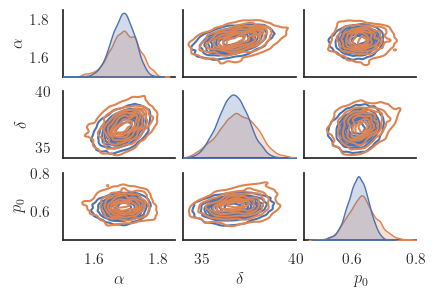

In [43]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import itertools

plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = True
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
keys = jax.random.split(OP_key, 10000)
sampling = jax.vmap(gauss.sampling_method, in_axes=(None, 0))
vars = [r'$\displaystyle \alpha$', r'$\displaystyle\delta$', r'$\displaystyle p_0$']
plt.figure(figsize=(3 * 1.5, 3 * 1))
limdelta = (34, 40)
limp0 = (0.45, 0.8)
limalpha = (1.5, 1.85)
lims = {0: {0: (limalpha, limalpha), 1: (limdelta, limalpha), 2: (limp0, limalpha)},
        1: {0: (limdelta, limalpha), 1: (limdelta, limdelta), 2: (limp0, limdelta)},
        2: {0: (limalpha, limp0), 1: (limdelta, limp0), 2: (limp0, limp0)}
        }
for _idx in range(len(PKL_titles)):
    if "ht_data" not in PKL_titles[_idx] and "heuristic_gaussian" in PKL_titles[_idx]:
        mypkld = PKLs[_idx]['res']
        samples = from_params_transform_to_params(sampling(mypkld[51][:-1], keys))
        pd_samples = pd.DataFrame(samples, columns=vars)
        pd_samples['name'] = "Fullcovariance Gaussian approximation"

_idx = -5
mypkld = PKLs[_idx]['chain']
samples = from_params_transform_to_params(mypkld[0][0])[1000:]
pd_samples_mcmc = pd.DataFrame(samples, columns=vars)
pd_samples_mcmc['name'] = "RWMH MCMC posterior"
pd_samples = pd.concat([pd_samples, pd_samples_mcmc])

g = sns.pairplot(pd_samples, hue="name", kind="kde", vars=vars, height=1, aspect=1.5)
g._legend.remove()
for idx1, idx2 in itertools.product(range(3), range(3)):
    g.axes[idx1, idx2].set_xlim(*lims[idx1][idx2][0])
    g.axes[idx1, idx2].set_ylim(*lims[idx1][idx2][1])

plt.savefig(f"pairplot_bsl_fcg_mcmc_concat{_idx}.pdf", dpi=300)

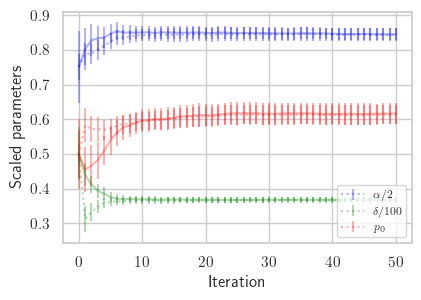

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = True
sns.set_theme(style="whitegrid", rc={"axes.facecolor": (0, 0, 0, 0)})
legends = [r'$\displaystyle \alpha/2$', r'$\displaystyle \delta/100$', r'$\displaystyle p_0$']
_scales = [2, 100, 1]
plt.figure(figsize=(3 * 1.5, 3 * 1))
colors = ['blue', 'green', 'red']
import numpy as np

keys = jax.random.split(OP_key, 10000)
sampling = jax.vmap(trunc.sampling_method, in_axes=(None, 0))
means = list()
stds = list()
titles = list()
for _idx in range(len(PKLs)):
    if "ht_data" not in PKL_titles[_idx] and "trunc" in PKL_titles[_idx] and "100_inv" in PKL_titles[_idx]:
        mypkld = PKLs[_idx]['res']
        size = min(mypkld.shape[0], 51)
        _means = np.zeros((size, 3))
        _std = np.zeros((size, 3))
        for i in range(size):
            keys = jax.random.split(keys.at[-1].get(), 10000)
            samples = sampling(mypkld[i][:-1], keys)
            _means[i] = jnp.mean(samples, axis=0)
            _std[i] = jnp.std(samples, axis=0)
        means.append(_means)
        stds.append(_std)
        titles.append(PKL_titles[_idx])
_scales = [2, 100, 1]
for i in range(3):
    for _idx in range(1):
        plt.errorbar(range(size), means[_idx][:, i] / _scales[i], yerr=stds[_idx][:, i] / _scales[i], alpha=0.3,
                     linestyle="-", color=colors[i])
        #plt.plot(range(size), means[_idx][:,i], label=titles[_idx][-39:], alpha=0.5)

keys = jax.random.split(OP_key, 10000)
sampling = jax.vmap(gauss.sampling_method, in_axes=(None, 0))
means = list()
stds = list()
titles = list()
covs = list()
for _idx in range(len(PKLs)):
    if "ht_data" not in PKL_titles[_idx] and "heuristic_gaussian" in PKL_titles[_idx]:
        mypkld = PKLs[_idx]['res']
        size = min(mypkld.shape[0], 51)
        _means = np.zeros((size, 3))
        _std = np.zeros((size, 3))
        _covs = np.zeros((size, 3, 3))
        for i in range(size):
            keys = jax.random.split(keys.at[-1].get(), 10000)
            samples = from_params_transform_to_params(sampling(mypkld[i][:-1], keys))
            _means[i] = jnp.mean(samples, axis=0)
            _std[i] = jnp.std(samples, axis=0)
            _covs[i] = jnp.cov(samples, rowvar=False)
        means.append(_means)
        stds.append(_std)
        covs.append(_covs)
        titles.append(PKL_titles[_idx])
for i in range(3):
    for _idx in range(1):
        plt.errorbar(range(size), means[_idx][:, i] / _scales[i], yerr=stds[_idx][:, i] / _scales[i], label=legends[i],
                     alpha=0.3, linestyle=":", color=colors[i])
plt.xlabel("Iteration")
plt.ylabel("Scaled parameters")
plt.legend(prop={'size': 8}, loc='lower right', facecolor='white')
plt.savefig("comparison.pdf", dpi=300, bbox_inches='tight')


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

samples = from_params_transform_to_params(PKLs[4]['chain'][0][0])
samples = samples[5000:]
plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = True
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

vars = [r'$\displaystyle \alpha$', r'$\displaystyle\delta$', r'$\displaystyle p_0$']

pd_samples = pd.DataFrame(samples, columns=vars)
sns.pairplot(pd_samples, kind="kde", vars=vars)
plt.savefig("pairplot_bsl_trueposterior.pdf", dpi=300)




In [39]:
PKL_titles

['heuristic_gaussian_200_100_inv_u_1_shrinkage_01_[0 2].pkl',
 'heuristic_trunc_gaussian_200_100_inv_u_1_shrinkage_05_[0 2].pkl',
 'heuristic_trunc_gaussian_200_10_inv_u_1_shrinkage_01_tgtlog10_[0 1].pkl',
 'heuristic_trunc_gaussian_200_10_inv_u_1_shrinkage_01_tgtlog10_[0 2].pkl',
 'heuristic_trunc_gaussian_200_100_inv_u_1_shrinkage_05_[0 0].pkl',
 'heuristic_trunc_gaussian_200_10_inv_u_1_shrinkage_05_[0 1].pkl',
 'heuristic_trunc_gaussian_200_10_inv_u_1_shrinkage_01_tgtlog10_[0 0].pkl',
 'heuristic_gaussian_200_100_inv_u_1_shrinkage_01_[0 1].pkl',
 'heuristic_trunc_gaussian_200_10_inv_u_1_shrinkage_05_[0 2].pkl',
 'rwmh_constant_sigma_100_10000_[0 4].pkl',
 'ht_data_63_66_[0 0].pkl',
 'heuristic_trunc_gaussian_200_100_inv_u_1_shrinkage_05_[0 1].pkl',
 'heuristic_trunc_gaussian_200_10_inv_u_1_shrinkage_05_[0 0].pkl',
 'heuristic_gaussian_200_100_inv_u_1_shrinkage_01_[0 0].pkl']